## Import Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math

np.random.seed(42) # For reproducibility

In [2]:
# Create a Neural Network class
class ThreeLayerNeuralNetwork:
    # Initialize the class
    def __init__(self, input_nodes, hidden_nodes, output_nodes, learning_rate, activation_function, Optimizer): 
        self.input_nodes = input_nodes
        self.hidden_nodes = hidden_nodes
        self.output_nodes = output_nodes
        self.learning_rate = learning_rate
        self.activation_function = activation_function
        self.Optimizer = Optimizer
        self.epoch_number = 0

    def change_learning_rate(self, learning_rate):
        self.learning_rate = learning_rate

    def change_activation_function(self, activation_function):
        self.activation_function = activation_function

    def change_Optimizer(self, Optimizer):
        self.Optimizer = Optimizer

    def change_hidden_nodes(self, hidden_nodes):
        self.hidden_nodes = hidden_nodes

    def _init_weight_matrices(self, input_nodes, hidden_nodes, output_nodes):
        # Initialize the weight matrices with random values
        self.weight_matrix_1 = np.random.randn(input_nodes, hidden_nodes)
        self.weight_matrix_2 = np.random.randn(hidden_nodes, output_nodes)
        self.prev_weight_matrix_1_gradient = np.zeros((input_nodes, hidden_nodes))
        self.prev_weight_matrix_2_gradient = np.zeros((hidden_nodes, output_nodes))
        self.prev_weight_matrix_1_update = np.random.randn(input_nodes, hidden_nodes)
        self.prev_weight_matrix_2_update = np.random.randn(hidden_nodes, output_nodes)

    def _init_bias_vectors(self, input_nodes, hidden_nodes, output_nodes):
        # Initialize the Bias Vector 1
        # The Size of the Bias Vector 1 is (hidden_nodes, 1)
        self.bias_vector_1 = np.zeros((1, self.hidden_nodes))
        # The Size of the Bias Vector 2 is (output_nodes, 1)
        self.bias_vector_2 = np.zeros((1, self.output_nodes))

    def _loss_function(self, y, y_hat):
        return np.mean((y - y_hat)**2)
    
    def _loss_function_grad(self, y, y_hat):
        return 2 * (np.array(y_hat - y))/(y.shape[0])
    
    def _activation_function(self, x):
        # Write Code for the Tanh, activation function
        if(self.activation_function == "tanh"):
            return np.tanh(x)
        elif(self.activation_function == "Leaky_Relu"):
            return np.maximum(0.01*x, x)
    
    def _grad_of_activation(self, x):
        if(self.activation_function == "tanh"):
            return 1 - np.tanh(x)**2
        elif(self.activation_function == "Leaky_Relu"):
            return np.where(x > 0, 1, 0.01)

    def _forward_pass(self, input_vector):
        # The Size of the Input Vector is (input_nodes, 1)
        self.input_vector = input_vector
        # print("Input Vector: ", self.input_vector)
        # The Size of the Hidden Layer is (hidden_nodes, 1)
        self.input_vector = self.input_vector.T
        self.activation_layer = np.dot(input_vector, self.weight_matrix_1) 
        # print("Activation Layer: ", self.activation_layer)
        self.hidden_layer = self._activation_function(self.activation_layer) + self.bias_vector_1
        # The Size of the Output Layer is (output_nodes, 1) 
        self.output_layer = np.dot(self.hidden_layer, self.weight_matrix_2) + self.bias_vector_2
        return self.output_layer

    def _backward_pass(self,target_vector):
        # Basically we need to obtain derivatives with respect to two weight matrices
        target_vector = np.array(target_vector)
        # First With Weight Matrix 2
        target_vector = target_vector.reshape(-1, 1) # Reshape into a (no.of samples, 1) vector
        # First, we need to calculate the derivative of the loss function with respect to the output layer
        Loss_Derivative = self._loss_function_grad(target_vector, self.output_layer)
        self.Weight_Matrix_2_Derivative = np.dot(self.hidden_layer.T, Loss_Derivative)

        # # Now, Find the Bias Vector
        Bias_Vector_2_Derivative = np.sum(Loss_Derivative, axis=0, keepdims=True)

        # First, we need to calculate the derivative of the loss function with respect to the hidden layer
        Loss_Derivative = np.dot(self.weight_matrix_2, Loss_Derivative.T)
        # Second, we need to Calculate the derivative of the hidden layer with respect to the activation layer
        Activation_Layer_Derivative = self._grad_of_activation(self.activation_layer)
        # Here the Activation_Layer_Derivative is of shape (25, 1) -> Which is the same as the hidden layer -> Multiply element wise
        Temp_Dertivative = np.multiply(Activation_Layer_Derivative, Loss_Derivative.T)
        self.Weight_Matrix_1_Derivative = np.dot(self.input_vector, Temp_Dertivative)

        # Now, Find the Bias Vector
        Bias_Vector_1_Derivative = np.sum(Temp_Dertivative, axis=0, keepdims=True)

        clip_value = 0.5  # You can adjust this threshold as needed

        # Clip gradients
        # self.Weight_Matrix_1_Derivative = np.clip(self.Weight_Matrix_1_Derivative, -clip_value, clip_value)
        # self.Weight_Matrix_2_Derivative = np.clip(self.Weight_Matrix_2_Derivative, -clip_value, clip_value)
        
        if self.Optimizer == "SGD":
        # Now, we have the derivatives of the loss function with respect to the weight matrices
        # Now, we need to update the weight matrices
        # Update the Weight Matrix 1
            self.weight_matrix_1 = self.weight_matrix_1 - self.learning_rate * self.Weight_Matrix_1_Derivative
            self.bias_vector_1 = self.bias_vector_1 - self.learning_rate * Bias_Vector_1_Derivative
            # Update the Weight Matrix 2
            self.weight_matrix_2 = self.weight_matrix_2 - self.learning_rate * self.Weight_Matrix_2_Derivative
            self.bias_vector_2 = self.bias_vector_2 - self.learning_rate * Bias_Vector_2_Derivative
        elif self.Optimizer == "Rprop":
            # Define Rprop parameters
            eta_plus = 1.2  # Learning rate increase factor
            eta_minus = 0.5  # Learning rate decrease factor
            delta_max = 50.0  # Maximum weight update value
        
            # Initialize update values (initialize to 0)
            delta_weight_matrix_1 = np.zeros((self.input_nodes, self.hidden_nodes))
            delta_weight_matrix_2 = np.zeros((self.hidden_nodes, self.output_nodes))
        
            # Loop over each weight in weight_matrix_1
            for i in range(self.input_nodes):
                for j in range(self.hidden_nodes):
                    gradient = self.Weight_Matrix_1_Derivative[i, j]
        
                    # Determine the update direction (sign change)
                    if gradient * self.prev_weight_matrix_1_gradient[i, j] >= 0:
                        delta_weight_matrix_1[i, j] = min(delta_weight_matrix_1[i, j] * eta_plus + 1e-3, delta_max)
                    elif gradient * self.prev_weight_matrix_1_gradient[i, j] < 0:
                        delta_weight_matrix_1[i, j] = max(delta_weight_matrix_1[i, j] * eta_minus, 1e-3)
        
                    # Update weights using the learning rate and update direction
                    self.weight_matrix_1[i, j] -= np.sign(gradient) * delta_weight_matrix_1[i, j] * self.learning_rate
        
            # Loop over each weight in weight_matrix_2 (similar to weight_matrix_1)
            for i in range(self.hidden_nodes):
                for j in range(self.output_nodes):
                    gradient = self.Weight_Matrix_2_Derivative[i, j]
        
                    if gradient * self.prev_weight_matrix_2_gradient[i, j] >= 0:
                        delta_weight_matrix_2[i, j] = min(delta_weight_matrix_2[i, j] * eta_plus + 1e-3, delta_max)
                    elif gradient * self.prev_weight_matrix_2_gradient[i, j] < 0:
                        delta_weight_matrix_2[i, j] = max(delta_weight_matrix_2[i, j] * eta_minus, 1e-3)
        
                    self.weight_matrix_2[i, j] -= np.sign(gradient) * delta_weight_matrix_2[i, j] * self.learning_rate
        
            # Update the previous gradients for the next iteration
            self.prev_weight_matrix_1_gradient = self.Weight_Matrix_1_Derivative
            self.prev_weight_matrix_2_gradient = self.Weight_Matrix_2_Derivative

        # elif self.Optimizer == "QuickProp":
        #     if self.epoch_number == 0:
        #         # Do regular SGD for the first epoch
        #         self.weight_matrix_1 = self.weight_matrix_1 - self.learning_rate * self.Weight_Matrix_1_Derivative
        #         self.bias_vector_1 = self.bias_vector_1 - self.learning_rate * Bias_Vector_1_Derivative
        #         self.weight_matrix_2 = self.weight_matrix_2 - self.learning_rate * self.Weight_Matrix_2_Derivative
        #         self.bias_vector_2 = self.bias_vector_2 - self.learning_rate * Bias_Vector_2_Derivative

        #         # Update the previous gradients for the next iteration
        #         self.prev_weight_matrix_1_update = self.Weight_Matrix_1_Derivative * self.learning_rate
        #         self.prev_weight_matrix_2_update = self.Weight_Matrix_2_Derivative * self.learning_rate

        #         self.prev_weight_matrix_1_gradient = self.Weight_Matrix_1_Derivative
        #         self.prev_weight_matrix_2_gradient = self.Weight_Matrix_2_Derivative

        #         self.epoch_number += 1
        #         print("Epoch Number: ", self.epoch_number)
        #     else:
        #         for i in range(self.input_nodes):
        #             for j in range(self.hidden_nodes):
        #                 gradient = self.Weight_Matrix_1_Derivative[i, j]
        #                 prev_update = self.prev_weight_matrix_1_update[i, j]
        #                 prev_gradient = self.prev_weight_matrix_1_gradient[i, j]

        #                 # Update weights using the learning rate and update direction
        #                 self.weight_matrix_1[i, j] -= (gradient * self.learning_rate)*np.abs(prev_update / (prev_gradient - gradient + 1e-3))

        #                 # Update the previous update values for the next iteration
        #                 self.prev_weight_matrix_1_update[i, j] = (gradient * self.learning_rate)*np.abs(prev_update / (prev_gradient - gradient + 1e-3))

        #         # Loop over each weight in weight_matrix_2 (similar to weight_matrix_1)
        #         for i in range(self.hidden_nodes):
        #             for j in range(self.output_nodes):
        #                 gradient = self.Weight_Matrix_2_Derivative[i, j]
        #                 prev_update = self.prev_weight_matrix_2_update[i, j]
        #                 prev_gradient = self.prev_weight_matrix_2_gradient[i, j]

        #                 self.weight_matrix_2[i, j] -= (gradient * self.learning_rate)*np.abs(prev_update / (prev_gradient - gradient + 1e-3))

        #                 self.prev_weight_matrix_2_update[i, j] = (gradient * self.learning_rate)*np.abs(prev_update / (prev_gradient - gradient + 1e-3))

        #         # Update the previous gradients for the next iteration
        #         self.prev_weight_matrix_1_gradient = self.Weight_Matrix_1_Derivative
        #         self.prev_weight_matrix_2_gradient = self.Weight_Matrix_2_Derivative

        elif self.Optimizer == "QuickProp":
            if self.epoch_number == 0:
                # Do regular SGD for the first epoch
                self.weight_matrix_1 = self.weight_matrix_1 - self.learning_rate * self.Weight_Matrix_1_Derivative
                self.bias_vector_1 = self.bias_vector_1 - self.learning_rate * Bias_Vector_1_Derivative
                self.weight_matrix_2 = self.weight_matrix_2 - self.learning_rate * self.Weight_Matrix_2_Derivative
                self.bias_vector_2 = self.bias_vector_2 - self.learning_rate * Bias_Vector_2_Derivative

                # Update the previous gradients for the next iteration
                self.prev_weight_matrix_1_update = self.Weight_Matrix_1_Derivative * self.learning_rate
                self.prev_weight_matrix_2_update = self.Weight_Matrix_2_Derivative * self.learning_rate

                self.prev_weight_matrix_1_gradient = self.Weight_Matrix_1_Derivative
                self.prev_weight_matrix_2_gradient = self.Weight_Matrix_2_Derivative

                self.epoch_number += 1
                print("Epoch Number: ", self.epoch_number)
            else:
                for i in range(self.input_nodes):
                    for j in range(self.hidden_nodes):
                        gradient = self.Weight_Matrix_1_Derivative[i, j]
                        prev_update = self.prev_weight_matrix_1_update[i, j]
                        prev_gradient = self.prev_weight_matrix_1_gradient[i, j]
                        # print("Prev Gradient Layer -1 ", prev_gradient - gradient)

                        # Update weights using the learning rate and update direction
                        self.weight_matrix_1[i, j] -= (gradient * self.learning_rate)*np.abs(prev_update / ( prev_gradient - gradient + 1e-12))
                        # Update the previous update values for the next iteration
                        self.prev_weight_matrix_1_update[i, j] = (gradient * self.learning_rate)*np.abs(prev_update / ( prev_gradient - gradient + 1e-12))

                # Loop over each weight in weight_matrix_2 (similar to weight_matrix_1)
                for i in range(self.hidden_nodes):
                    for j in range(self.output_nodes):
                        gradient = self.Weight_Matrix_2_Derivative[i, j]
                        prev_update = self.prev_weight_matrix_2_update[i, j]
                        prev_gradient = self.prev_weight_matrix_2_gradient[i, j]
                        # print("Prev Gradient Layer -2 ", prev_gradient - gradient)

                        self.weight_matrix_2[i, j] -= (gradient * self.learning_rate)*np.abs(prev_update / ( -prev_gradient + gradient + 1e-12))
                        self.prev_weight_matrix_2_update[i, j] = (gradient * self.learning_rate)*np.abs(prev_update / (-prev_gradient + gradient + 1e-12))

                # Update the previous gradients for the next iteration
                self.prev_weight_matrix_1_gradient = self.Weight_Matrix_1_Derivative
                self.prev_weight_matrix_2_gradient = self.Weight_Matrix_2_Derivative

                self.epoch_number += 1
                # print("Epoch Number: ", self.epoch_number)

        # # Clear the Derivative Variables
        self.Weight_Matrix_1_Derivative = None
        self.Weight_Matrix_2_Derivative = None

    def Train(self, train_data_x, train_data_y, epochs, test_data_x, test_data_y):
        # Initialize the weights first
        self._init_weight_matrices(self.input_nodes, self.hidden_nodes, self.output_nodes)
        # Initialize the bias first
        self._init_bias_vectors(self.input_nodes, self.hidden_nodes, self.output_nodes)
        # Now, we need to train the model
        # We need to iterate over the training data
        # Plot the Losses Dynamically 

        # Create a figure and axis for dynamic plotting
        plt.ion()  # Turn on interactive mode for dynamic updates
        fig, ax = plt.subplots()

        losses = []
        test_loss = []

        for epoch in range(epochs):
            # Train the model
            self._forward_pass(train_data_x)
            self._backward_pass(train_data_y)

            # Create a copy of the train_data_y
            train_data_y_copy = train_data_y.copy()
            train_data_y_copy = train_data_y_copy.reshape(-1, 1)
            train_data_y_copy = train_data_y_copy.T

            loss = self._loss_function(train_data_y_copy, self.output_layer.T)
            losses.append(loss)

            # Test the model
            self._forward_pass(test_data_x)
            test_loss.append(self._loss_function(test_data_y, self.output_layer.T))

        # Plot both test loss and train loss on the same curve

        ax.clear()
        ax.plot(losses, label='Loss')
        ax.plot(test_loss, label='Test Loss')
        ax.set_xlabel('Epoch')
        ax.set_ylabel('Loss')
        ax.legend()
        plt.pause(0.1)  # Pause for a short time to allow the plot to update
        
        plt.ioff()
        plt.show()

    def Test(self, x_test):
        # We need to iterate over the test data
        return self._forward_pass(x_test)

    def Predict(self, data_point):
        pass



## Load the Data

In [3]:
# Load the Data
data = pd.read_csv('./Concrete_Data.csv', header=None)
# Remove the First Row
data = data.iloc[1:]
# Print the Shape of the Data
print(data.shape)

# Target Variable 
target_variable = data.iloc[:, -1]
# Input Variables
input_variables = data.iloc[:, 0:8]

# Convert both to numpy arrays
target_variable = np.array(target_variable, dtype=np.float32)
input_variables = np.array(input_variables, dtype=np.float32)

print(target_variable.shape)
print(input_variables.shape)

# Preprocess the Data
########################

########################

# Split the Data into Train and Test
# Randomly choose 70% and 30% of the data
Total_samples = target_variable.shape[0]
Train_percentage = 0.7

Train_Samples = 0.7*Total_samples
Test_Samples = 0.3*Total_samples

# Shuffle The Data
indices = np.arange(Total_samples)
np.random.shuffle(indices)

# Split this data
Train_indices = indices[:int(Train_Samples)]
Test_indices = indices[int(Train_Samples):]

X_Train = input_variables[Train_indices]
Y_Train = target_variable[Train_indices]
x_test = input_variables[Test_indices]
y_test = target_variable[Test_indices]

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_Train = scaler.fit_transform(X_Train)
x_test = scaler.transform(x_test)
Y_Train = Y_Train.reshape(-1, 1)
y_test = y_test.reshape(-1, 1)
Y_Train = scaler.fit_transform(Y_Train)
y_test = scaler.transform(y_test)

(1030, 9)
(1030,)
(1030, 8)


# Training the Neural Network

- Basically, I am normalizing the data, in the Network using sklearn's Standard Scaler Function
- For each setting we have to report the:
    - Lowest MSE on train data and test data.
    - Graph of MSE over train data vs epochs.
    - Graph of MSE over test data vs epochs.

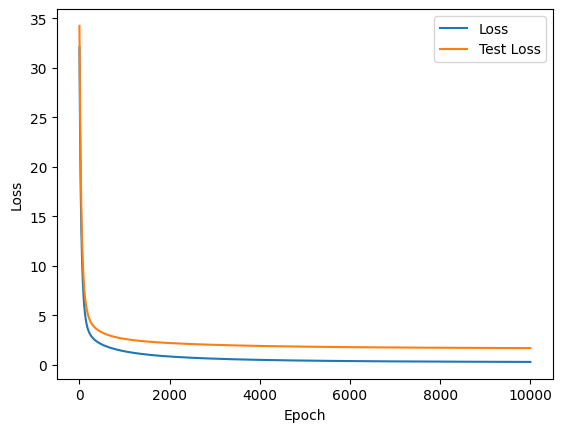

Loss for Network Variation:  1  is:  0.37102724887979305


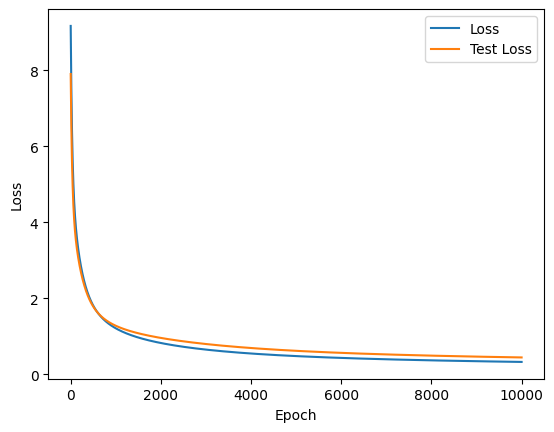

Loss for Network Variation:  2  is:  0.4424079423057254


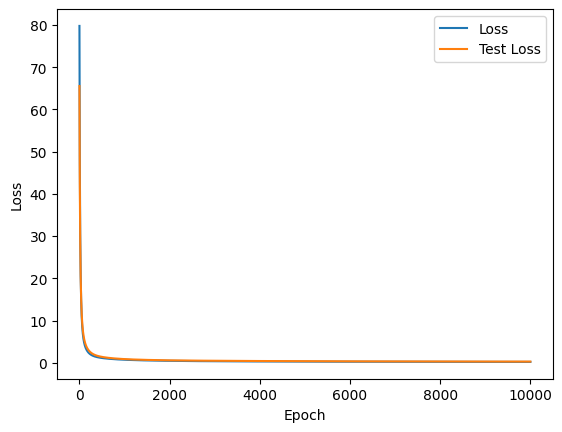

Loss for Network Variation:  3  is:  0.28794761047411443


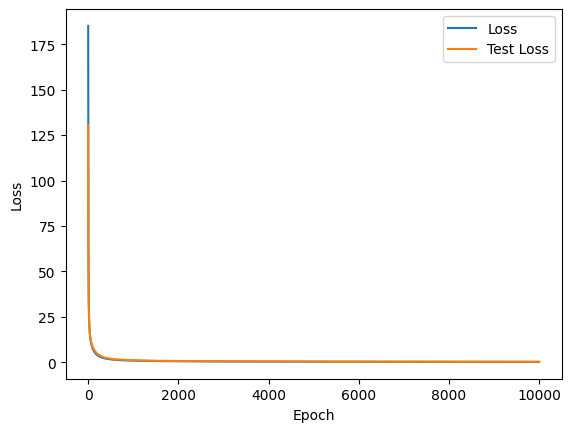

Loss for Network Variation:  4  is:  0.37293922692515075


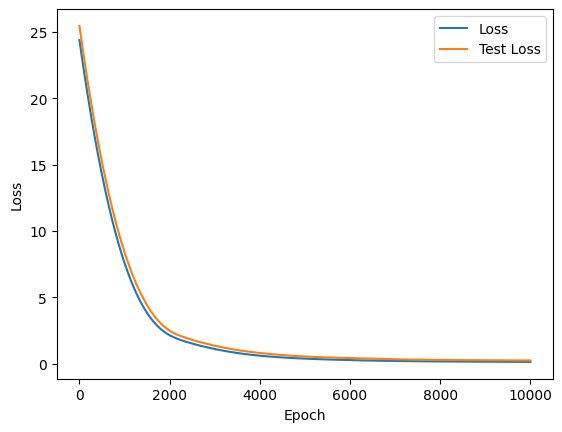

Loss for Network Variation:  5  is:  0.24856529802465718


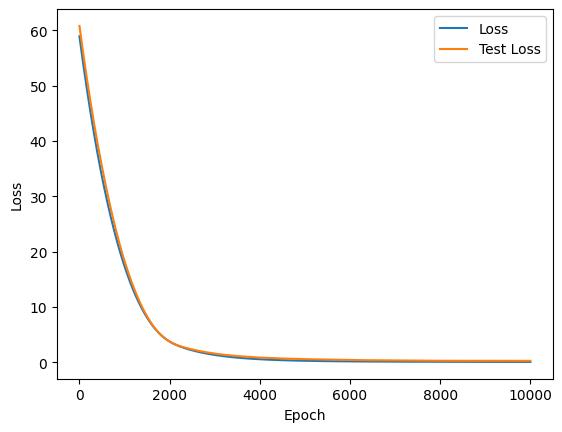

Loss for Network Variation:  6  is:  0.2744377970510156


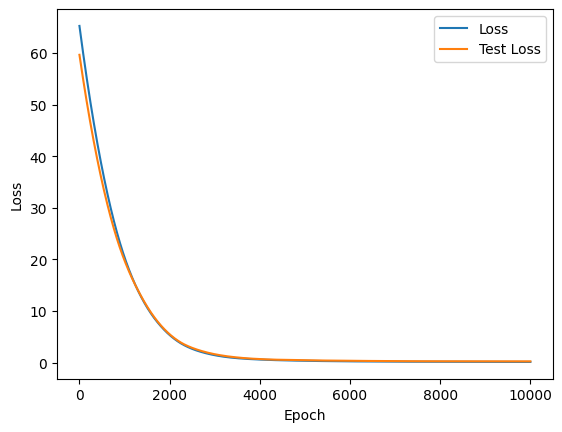

Loss for Network Variation:  7  is:  0.2301121215148394


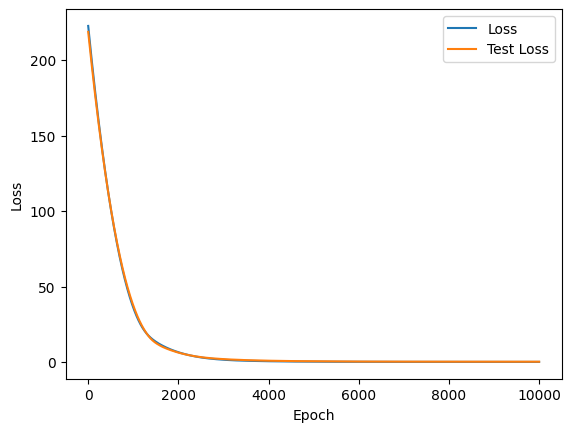

Loss for Network Variation:  8  is:  0.2492217500134135
Epoch Number:  1


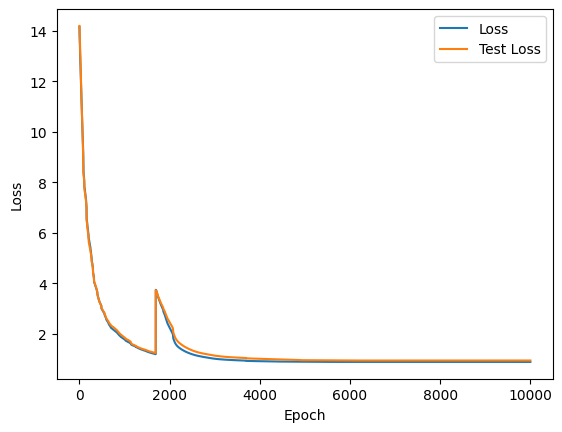

Loss for Network Variation:  9  is:  0.9420204030589173
Epoch Number:  1


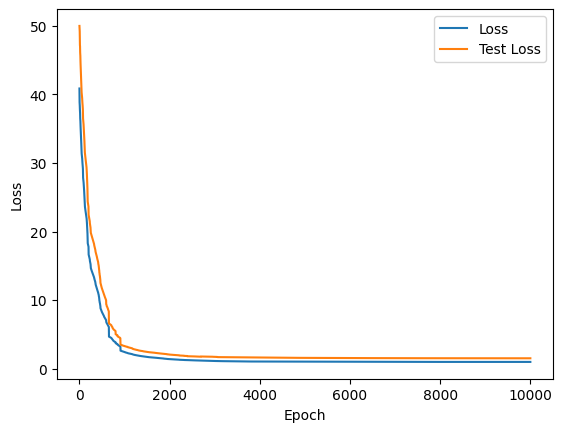

Loss for Network Variation:  10  is:  1.4945128015786007
Epoch Number:  1


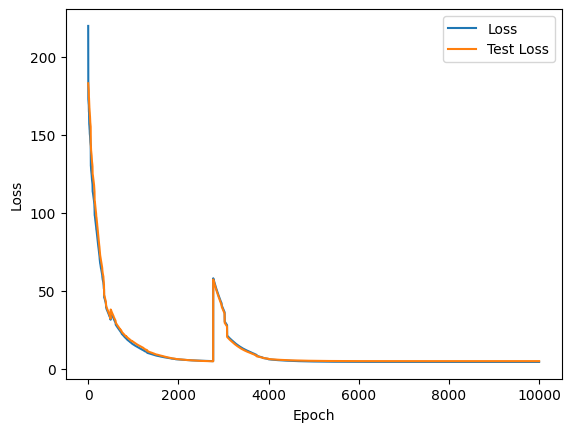

Loss for Network Variation:  11  is:  5.073528721945751
Epoch Number:  1


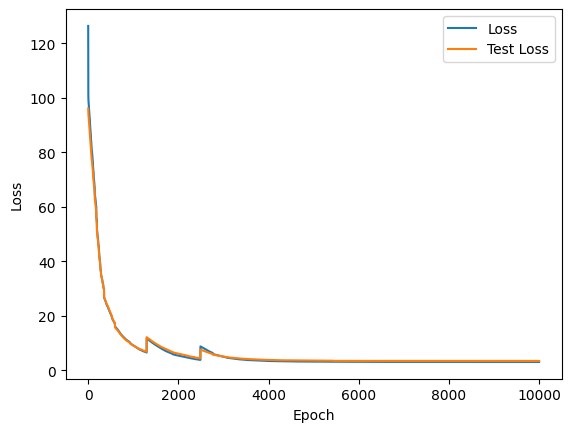

Loss for Network Variation:  12  is:  3.40111967923004


In [4]:
# Create a Instance of The N.N class
Neural_Network = ThreeLayerNeuralNetwork(input_nodes=8, hidden_nodes=25, output_nodes=1, learning_rate=0.001, activation_function='tanh', Optimizer='SGD')

# Consider the following 4 network variations
# 1. 25 hidden units, tanh activation function.
# 2. 50 hidden units, tanh activation function.
# 3. 25 hidden units, Leaky ReLU activation function.
# 4. 50 hidden units, Leaky ReLU activation function

# Create a Dictionary with above values
Temp_Dict = {
    1: [25, 'tanh', 'SGD'], 
    2: [50, 'tanh', 'SGD'],
    3: [25, 'Leaky_Relu', 'SGD'],
    4: [50, 'Leaky_Relu', 'SGD'],
    5: [25, 'tanh', 'Rprop'],
    6: [50, 'tanh', 'Rprop'],
    7: [25, 'Leaky_Relu', 'Rprop'],
    8: [50, 'Leaky_Relu', 'Rprop'],
    9: [25, 'tanh', 'QuickProp'],
    10: [50, 'tanh', 'QuickProp'],
    11: [25, 'Leaky_Relu', 'QuickProp'],
    12: [50, 'Leaky_Relu', 'QuickProp']
}

for i in Temp_Dict:
    # Create a Instance of The N.N class

    Neural_Network = ThreeLayerNeuralNetwork(input_nodes=8, hidden_nodes=Temp_Dict[i][0], output_nodes=1, learning_rate=0.001, activation_function=Temp_Dict[i][1], Optimizer=Temp_Dict[i][2])

    # For Rprop adjust the L.R
    if Temp_Dict[i][2] == "Rprop":
        Neural_Network.change_learning_rate(0.1)

    Neural_Network.Train(X_Train, Y_Train, epochs=10000, test_data_x=x_test, test_data_y=y_test)
    y_hat = Neural_Network.Test(x_test)
    y_hat = y_hat.reshape(-1, 1)
    y_hat = y_hat.T
    y_test = y_test.reshape(-1, 1)
    y_test = y_test.T
    print("Loss for Network Variation: ", i, " is: ", Neural_Network._loss_function(y_test, y_hat))

    
